In [1]:
# Task B: Train RNN on FSDD 
# - full precision 32 float
# - close to comparable designs (current deviation -6%, fixable by scaling network and tuning hyperparameters)
# - RNN layer sizing (64x64x2+64x2)x4bytes = ~33kB < 36 kB from Task B constraint

In [2]:
import glob
import pandas as pd
import torch
import random
from tqdm import tqdm
import torch.quantization as quantization

from collections import OrderedDict

from sigproc import gen_logmel, feat2img
import math

In [3]:
# mainly adapted from https://github.com/saztorralba/CNNWordReco due to following
# - deeplake / hub version broken -> replaced with original wavs (cloned orig repo: https://github.com/Jakobovski/free-spoken-digit-dataset)
# - logmel suitable for detection of spoken speech -> normalized, resampled, high-pass filtered, time axis scaling

In [4]:
args = {
    'train_val_percentage': 0.1,
    'xsize': 20,
    'ysize': 20,
    'rnn_layers': 3,
    'rnn_hidden': 64,
    'rnn_outputs': 10,
    'epochs': 1000,
    'batch_size': 32,
    'learning_rate': 0.001,
    'device': 'cpu',
    'verbose': 1,
    'augment': False,
    'vocab': OrderedDict({'ZERO': 0, 'ONE': 1, 'TWO': 2, 'THREE': 3, 'FOUR': 4, 'FIVE': 5, 'SIX': 6, 'SEVEN': 7, 'EIGHT': 8, 'NINE': 9})
}

In [5]:
## labels and paths in pd frame
wavfiles = glob.glob('./free-spoken-digit-dataset/recordings/*.wav')
speakers = [file.split('/')[-1].split('_')[1] for file in wavfiles]
words = [list(args['vocab'].keys())[int(file.split('/')[-1].split('_')[0])] for file in wavfiles]
rec_number = [int(file.split('/')[-1].split('_')[2].split('.')[0]) for file in wavfiles]
data = pd.DataFrame({'wavfile':wavfiles,'speaker':speakers,'word':words,'rec_number':rec_number})

## train/test split according to https://github.com/Jakobovski/free-spoken-digit-dataset
train_data = data.loc[data['rec_number']>=5].reset_index(drop=True)
test_data = data.loc[data['rec_number']<5].reset_index(drop=True)

In [6]:
# log mels for audio; time scaled by PIL.Image to xsize, 40 nmels
def load_data(data,cv=False,**kwargs):
    n_samples = len(data)
    dataset = torch.zeros((n_samples,kwargs['ysize'],kwargs['xsize']),dtype=torch.uint8)
    labels = torch.zeros((n_samples),dtype=torch.uint8)
    for i in tqdm(range(n_samples),disable=(kwargs['verbose']<2)):
        path = data['wavfile'][i]
        dataset[i,:,:] = torch.from_numpy(feat2img(gen_logmel(path,(kwargs['n_mels'] if 'n_mels' in kwargs else 40),(kwargs['sampling'] if 'sampling' in kwargs else 8000),True),kwargs['ysize'],kwargs['xsize']))
        labels[i] = kwargs['vocab'][data['word'][i]]

    if cv == False:
        return dataset, labels

    #Do random train/validation split
    idx = [i for i in range(n_samples)]
    random.shuffle(idx)
    trainset = dataset[idx[0:int(n_samples*(1-kwargs['train_val_percentage']))]]
    trainlabels = labels[idx[0:int(n_samples*(1-kwargs['train_val_percentage']))]]
    validset = dataset[idx[int(n_samples*(1-kwargs['train_val_percentage'])):]]
    validlabels = labels[idx[int(n_samples*(1-kwargs['train_val_percentage'])):]]
    return trainset, validset, trainlabels, validlabels

def load_test_data(data,**kwargs):
    n_samples = len(data)
    dataset = torch.zeros((n_samples,kwargs['ysize'],kwargs['xsize']),dtype=torch.uint8)
    labels = torch.zeros((n_samples),dtype=torch.uint8)
    for i in tqdm(range(n_samples),disable=(kwargs['verbose']<2)):
        path = data['wavfile'][i]
        dataset[i,:,:] = torch.from_numpy(feat2img(gen_logmel(path,(kwargs['n_mels'] if 'n_mels' in kwargs else 40),(kwargs['sampling'] if 'sampling' in kwargs else 8000),True),kwargs['ysize'],kwargs['xsize']))
        labels[i] = kwargs['vocab'][data['word'][i]]

    return dataset, labels

In [7]:
trainset, validset, trainlabels, validlabels = load_data(train_data,True,**args)
print(trainset.shape, validset.shape)
testset, testlabels = load_test_data(test_data,**args)
print(testset.shape)

torch.Size([2430, 20, 20]) torch.Size([270, 20, 20])
torch.Size([300, 20, 20])


In [8]:
class FSDNN_RNN(torch.nn.Module):
    def __init__(self, input_channels, hidden_size, num_layers, output_size):
        super(FSDNN_RNN, self).__init__()
        self.rnn = torch.nn.RNN(input_size=input_channels, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True)  # (batch, seq, features)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # RNN output
        out = self.fc(out[:, -1, :])  # Take last time step for classification
        return out

In [9]:
model_pre = FSDNN_RNN(args['xsize'], args['rnn_hidden'], args['rnn_layers'], args['rnn_outputs'])
model_pre.load_state_dict(torch.load('chkpt_t1_93.pt'), strict=False) #load pretrained 

<All keys matched successfully>

Parameter containing:
tensor([[ 0.0679, -0.0823, -0.0041,  ...,  0.0254,  0.0128, -0.0253],
        [ 0.0735,  0.0864,  0.1058,  ..., -0.0245,  0.1065, -0.0037],
        [-0.0521,  0.0396, -0.0342,  ...,  0.1165,  0.1053,  0.0856],
        ...,
        [ 0.0519, -0.0806,  0.0717,  ...,  0.0081, -0.0615, -0.0715],
        [ 0.0030, -0.1284, -0.0730,  ...,  0.1342,  0.1367,  0.1889],
        [ 0.0565,  0.0070,  0.0078,  ..., -0.1653, -0.0629, -0.0161]],
       requires_grad=True)


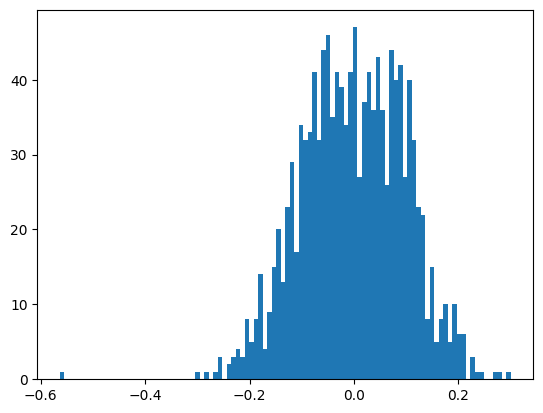

Parameter containing:
tensor([[ 0.0556, -0.1079,  0.0358,  ..., -0.1082,  0.1462, -0.0223],
        [-0.0464,  0.0769, -0.1030,  ...,  0.0471, -0.0271,  0.0440],
        [-0.1069,  0.1892, -1.2870,  ...,  0.0118,  0.0428,  0.0607],
        ...,
        [ 0.1797, -0.1258,  0.2147,  ..., -1.2317,  0.1570, -0.0104],
        [-0.1480, -0.1085, -0.0893,  ..., -0.0344, -0.8271, -0.0282],
        [ 0.2626, -0.4148, -0.0369,  ...,  0.0110,  0.2263, -1.6985]],
       requires_grad=True)


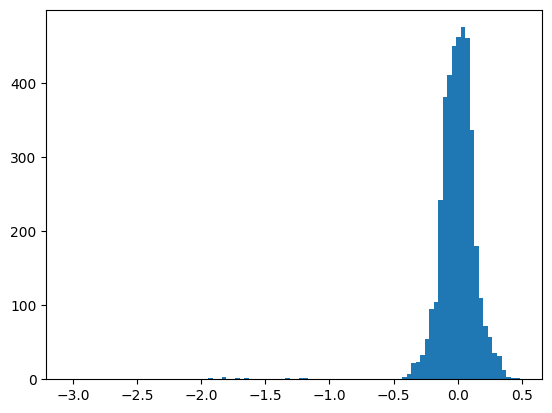

Parameter containing:
tensor([-0.1383,  0.1128,  0.1649, -0.1082, -0.0561, -0.2248, -0.0673,  0.0796,
         0.1301,  0.2022,  0.1072,  0.0081, -0.0283, -0.2874, -0.0107,  0.0730,
        -0.0276, -0.0125, -0.2482,  0.0068, -0.1041,  0.1944,  0.0469,  0.1369,
         0.2724, -0.1690, -0.0562, -0.1303, -0.0369, -0.0654, -0.1283, -0.0299,
        -0.1605,  0.0692, -0.2267,  0.1342,  0.0870,  0.0142,  0.0737, -0.0878,
        -0.0795,  0.0136, -0.0728, -0.0485,  0.0615, -0.0350, -0.0117,  0.0011,
         0.0272, -0.0713,  0.1888, -0.1034,  0.0379,  0.0409, -0.0167,  0.0964,
        -0.0370, -0.0571, -0.0836, -0.0760,  0.1589,  0.0031,  0.0057, -0.3768],
       requires_grad=True)


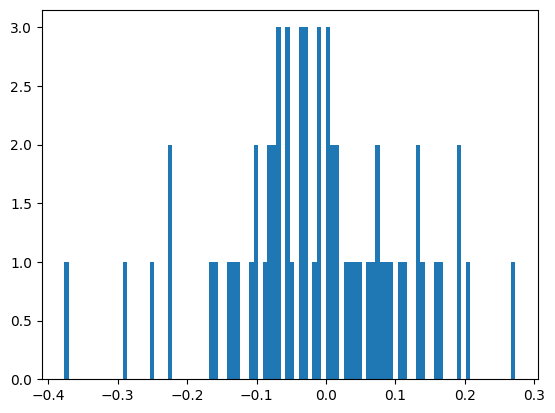

Parameter containing:
tensor([-0.1088, -0.0991,  0.1135, -0.0705, -0.1133, -0.2731, -0.0440,  0.0138,
        -0.0098,  0.2691, -0.1006,  0.0559,  0.1210, -0.3031,  0.0307, -0.1168,
         0.1127, -0.1074, -0.1200, -0.0737,  0.1044,  0.2706, -0.0773, -0.0424,
         0.3397, -0.0586, -0.0236, -0.0975,  0.0932, -0.1927, -0.1134,  0.0717,
         0.0061, -0.0048, -0.1802,  0.0168,  0.0238, -0.0199, -0.1103, -0.0120,
         0.0616, -0.0805, -0.1398, -0.1043, -0.0490,  0.0247, -0.1229, -0.0808,
        -0.1020, -0.0155,  0.0588, -0.2202,  0.0784, -0.1090,  0.0883,  0.0411,
         0.0602, -0.0559,  0.0316, -0.2600, -0.0316, -0.1113,  0.0941, -0.2053],
       requires_grad=True)


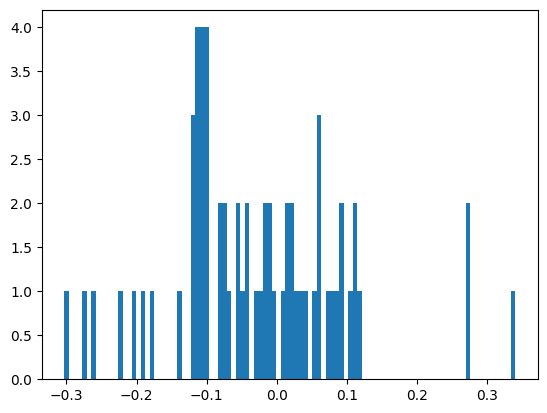

Parameter containing:
tensor([[ 0.0158,  0.1159, -0.0170,  ...,  0.1416, -0.0311, -0.0085],
        [ 0.1058,  0.0481,  0.0523,  ..., -0.0723, -0.0021,  0.0050],
        [-0.0188,  0.0320, -0.0255,  ...,  0.0112, -0.0717,  0.0273],
        ...,
        [-0.0417,  0.1064,  0.1551,  ..., -0.1022,  0.0879, -0.0036],
        [ 0.0029, -0.1028,  0.1203,  ..., -0.1587,  0.0400, -0.1143],
        [ 0.1598,  0.0573,  0.0813,  ..., -0.1018,  0.0615, -0.0606]],
       requires_grad=True)


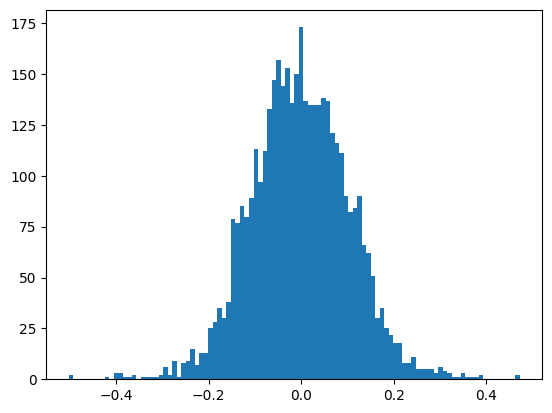

Parameter containing:
tensor([[ 0.1090,  0.2473,  0.2214,  ..., -0.1154, -0.0978,  0.1580],
        [-0.1777, -0.0122,  0.0561,  ...,  0.0578, -0.1869, -0.0698],
        [ 0.2301, -0.1043,  0.3462,  ...,  0.0944, -0.1340,  0.1450],
        ...,
        [ 0.0276,  0.0284,  0.0685,  ...,  0.1052,  0.1123, -0.0541],
        [-0.2443, -0.1747, -0.1786,  ..., -0.0639, -0.1055,  0.0103],
        [ 0.0948,  0.2595,  0.1522,  ..., -0.0682, -0.0515, -0.0564]],
       requires_grad=True)


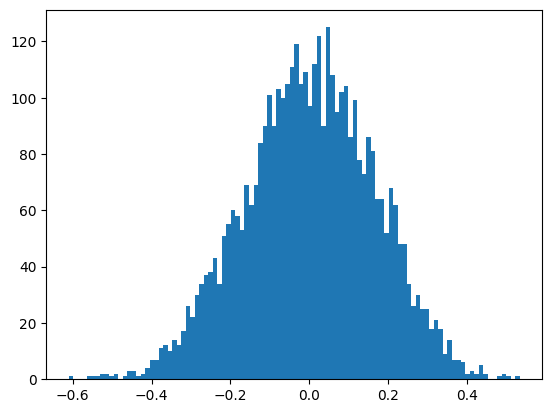

Parameter containing:
tensor([ 0.1004,  0.0367,  0.1214, -0.0781, -0.0024,  0.0389, -0.1293,  0.0139,
        -0.0563, -0.0912,  0.0341,  0.0871, -0.0646,  0.1516, -0.0755, -0.1470,
         0.0997, -0.0279,  0.1366, -0.0337,  0.1575, -0.0478,  0.0678,  0.1462,
         0.0729, -0.1043,  0.0010, -0.1344, -0.0442, -0.0887, -0.0648,  0.1605,
        -0.0479,  0.1854,  0.0112,  0.0784, -0.1121,  0.0521, -0.0081, -0.0674,
        -0.1049,  0.0396, -0.0725,  0.0196, -0.0616, -0.0612, -0.0711, -0.0775,
        -0.0796, -0.1034,  0.1404, -0.0418,  0.1450, -0.0512, -0.0631, -0.0782,
        -0.0682, -0.0938, -0.0125,  0.0937,  0.0090,  0.0420, -0.1176,  0.0300],
       requires_grad=True)


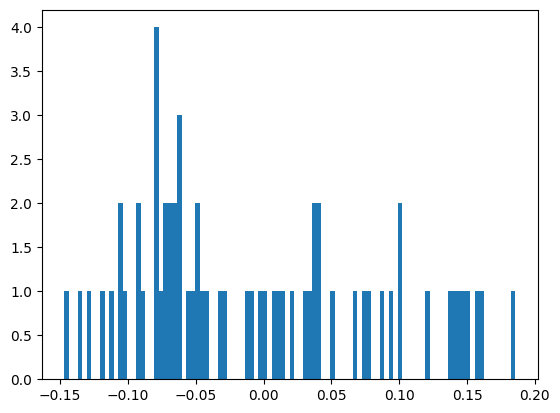

Parameter containing:
tensor([ 0.1540,  0.0695,  0.0419,  0.0629,  0.0365,  0.0592,  0.0343,  0.0400,
        -0.1749, -0.0835, -0.1114,  0.0114, -0.0506,  0.1079, -0.1324, -0.1535,
        -0.0726, -0.0636,  0.0744,  0.0817, -0.0307,  0.1056, -0.0018,  0.0405,
        -0.0749, -0.0504, -0.0781,  0.0256, -0.0404, -0.0993, -0.0093,  0.1764,
        -0.0442,  0.0972, -0.0643, -0.0663, -0.0024,  0.0210, -0.0717,  0.0044,
        -0.0262,  0.0678,  0.0741, -0.0955, -0.0087, -0.1011,  0.0709, -0.0247,
        -0.0945, -0.0077,  0.1011, -0.0653, -0.0152, -0.0168, -0.1215,  0.0018,
         0.0817, -0.1264, -0.0088, -0.0932,  0.1271, -0.1069, -0.0595, -0.0758],
       requires_grad=True)


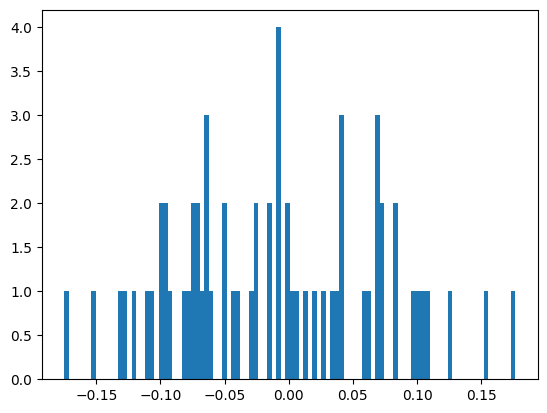

Parameter containing:
tensor([[-0.0582,  0.0181,  0.1527,  ..., -0.1802, -0.1828, -0.0276],
        [-0.1600,  0.0391, -0.0899,  ..., -0.1023,  0.0257,  0.1374],
        [-0.1259, -0.0323, -0.1859,  ..., -0.3907,  0.1378,  0.0535],
        ...,
        [ 0.0431,  0.1685,  0.0541,  ..., -0.0254,  0.0491, -0.0139],
        [ 0.0521, -0.1013, -0.1189,  ..., -0.0761, -0.0503, -0.0673],
        [ 0.0074, -0.2487, -0.0714,  ..., -0.3120, -0.0140, -0.1427]],
       requires_grad=True)


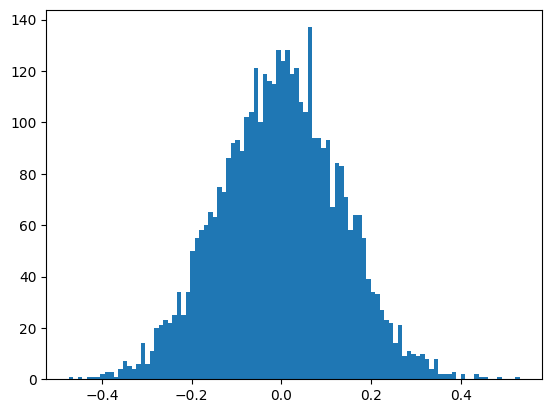

Parameter containing:
tensor([[ 0.3355,  0.1225,  0.0732,  ...,  0.0144,  0.0090,  0.2433],
        [-0.0110,  0.3383,  0.0193,  ...,  0.4438, -0.0952,  0.0093],
        [ 0.0724, -0.2858,  0.3130,  ..., -0.0501, -0.3510,  0.1370],
        ...,
        [-0.1584,  0.0403,  0.0941,  ...,  0.4522, -0.1064,  0.0334],
        [-0.0297, -0.1514, -0.1480,  ...,  0.0590,  0.1158,  0.0525],
        [-0.0794, -0.2760,  0.0843,  ...,  0.0223,  0.2395,  0.0766]],
       requires_grad=True)


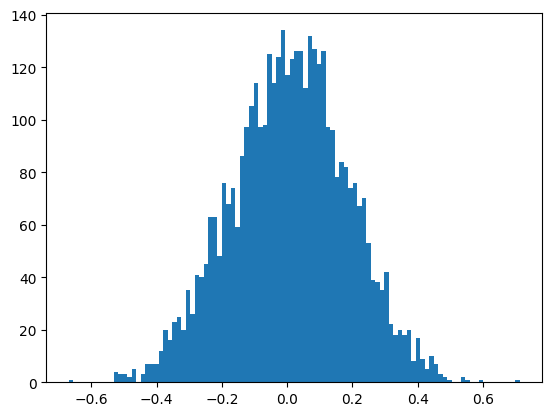

Parameter containing:
tensor([ 0.1757, -0.0641, -0.0061,  0.0849, -0.1442,  0.0341, -0.0853, -0.0125,
        -0.0474, -0.0399,  0.0758,  0.2778,  0.0140,  0.0843,  0.1420,  0.0292,
         0.0403,  0.0604,  0.1115, -0.0349, -0.0818,  0.0452, -0.0166, -0.1673,
         0.0500,  0.0449,  0.0770,  0.1482, -0.0347, -0.0445, -0.0011, -0.1478,
        -0.0021, -0.1005,  0.0786,  0.0834, -0.0610, -0.2207, -0.0040,  0.1440,
         0.0699,  0.0783, -0.0697, -0.0900, -0.0499, -0.0705,  0.2045, -0.0557,
        -0.0823,  0.0619, -0.0132, -0.1678,  0.1199,  0.0661,  0.2174,  0.2471,
        -0.0832, -0.0822,  0.2163, -0.1758, -0.1181,  0.0114, -0.1000, -0.0711],
       requires_grad=True)


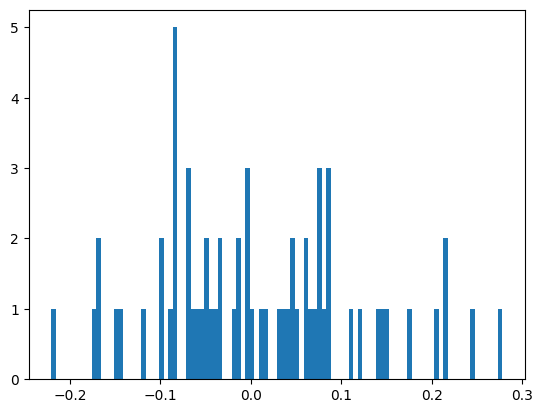

Parameter containing:
tensor([ 0.1707,  0.0974,  0.0474,  0.1039, -0.1493, -0.1080,  0.0071,  0.1639,
         0.0278,  0.0639,  0.1601,  0.2514, -0.0573,  0.1341,  0.0474, -0.0020,
        -0.2066, -0.0218,  0.0240,  0.0748, -0.2451,  0.0206,  0.0793, -0.1668,
        -0.1368,  0.0675,  0.1922,  0.0179,  0.0436,  0.0383,  0.0607, -0.0629,
        -0.0496, -0.0680,  0.0498,  0.1652,  0.0146, -0.2230,  0.0727,  0.0534,
         0.1463, -0.0208,  0.1199, -0.1026,  0.0949, -0.0254,  0.2628,  0.0347,
        -0.0239, -0.0878, -0.0534, -0.1619, -0.0686, -0.0562,  0.1425,  0.2427,
        -0.2532, -0.1437,  0.2009, -0.2334, -0.1268,  0.1804,  0.0696, -0.1206],
       requires_grad=True)


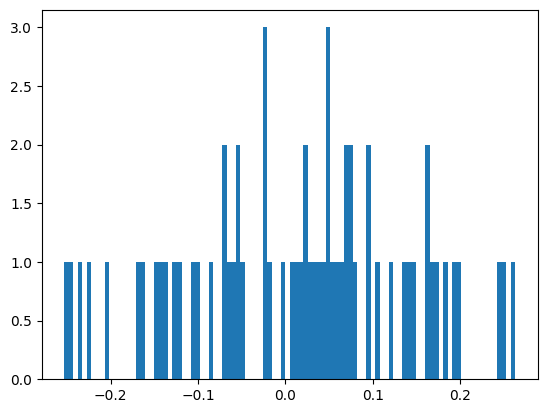

Parameter containing:
tensor([[ 3.7720e-01, -5.9544e-01,  8.4694e-01, -1.0823e+00, -1.9606e-01,
         -2.9827e-01, -4.6458e-01,  3.8427e-01,  8.1578e-01,  2.3498e-01,
          2.6860e-01, -2.9043e-01, -6.2122e-02, -1.5294e+00,  3.0640e-01,
         -3.5133e-01, -2.2807e-01,  3.6283e-01, -9.9202e-01, -1.6852e+00,
         -6.0402e-02, -1.8945e-01, -1.7988e-01,  7.4213e-01, -2.4446e-01,
         -2.2699e-01,  1.7896e+00, -9.3719e-01,  4.0530e-01, -5.8354e-01,
         -9.7669e-01, -2.7306e-01, -2.9296e-01, -1.9699e-01, -1.8443e-01,
         -5.5356e-01,  8.3104e-01, -2.5669e-01, -1.1120e+00, -5.7822e-01,
          3.5361e-01, -3.3876e-01,  1.1478e-01,  2.9907e-01, -5.4316e-01,
         -4.3856e-01,  2.3401e-01, -1.5886e+00, -5.8810e-02,  6.3106e-01,
         -1.1898e+00,  5.2441e-01,  3.8191e-01, -2.9076e-01, -1.5244e+00,
         -1.8792e+00,  7.7494e-02,  1.5892e+00, -1.1872e+00, -8.2383e-01,
         -5.2906e-01, -9.6676e-01, -2.1270e-01,  1.2050e-01],
        [-6.7458e-01,  1.460

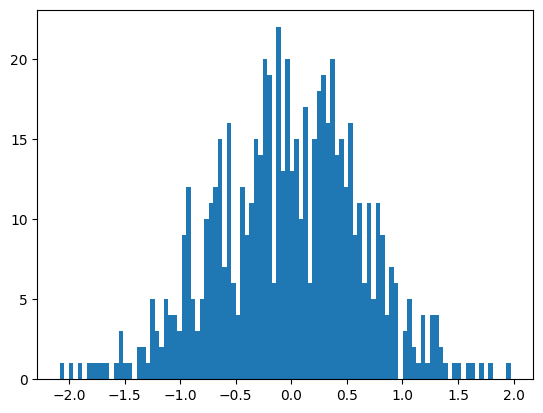

Parameter containing:
tensor([-0.0392, -0.1780,  0.3046, -0.0668,  0.1588,  0.1937,  0.0151, -0.0793,
        -0.0868, -0.3488], requires_grad=True)


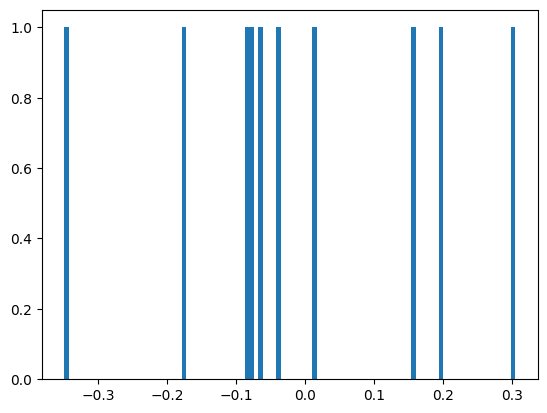

In [10]:
import matplotlib.pyplot as plt

for params in model_pre.parameters():
    print(params)
    plt.hist(params.detach().numpy().flatten(), bins=100)
    plt.show()

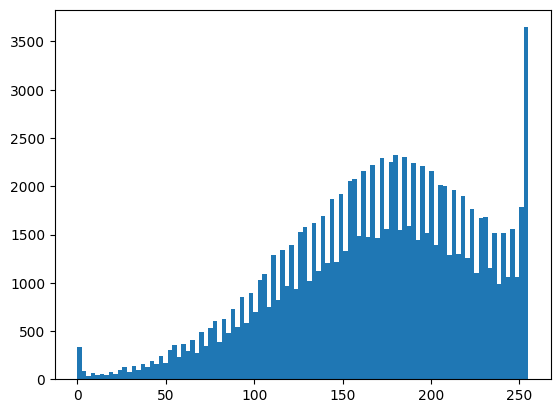

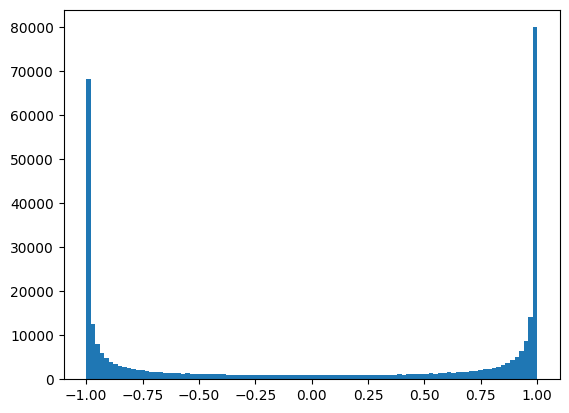

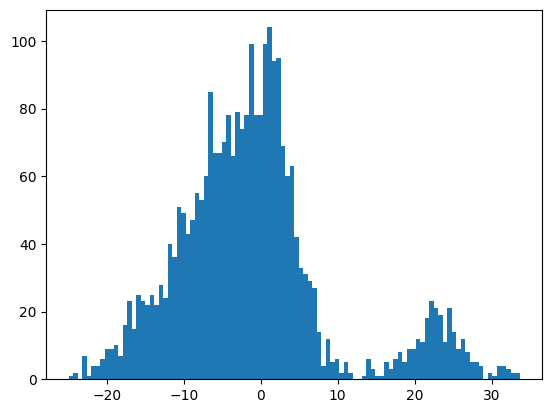

In [11]:
# Dictionary to store activations
activations = {"input": None, "hidden_states": {}, "output": None}

# Hook function to capture input, hidden, and output activations
def hook_fn(module, input, output):
    activations["hidden_states"][module] = output[0].detach().numpy()

model_pre.rnn.register_forward_hook(hook_fn)

activations["input"] = validset.detach().numpy()
with torch.no_grad():
    fc_output = model_pre(validset.clone().float())
activations["output"] = fc_output.detach().numpy()

plt.hist(activations["input"].flatten(), bins=100)
plt.show()
plt.hist(activations["hidden_states"][model_pre.rnn].flatten(), bins=100)
plt.show()
plt.hist(activations["output"].flatten(), bins=100)
plt.show()


# # Convert activations to NumPy
# input_act = activations["input"][0]  # Shape: (seq_len, input_size)
# output_act = activations["output"][0]  # Shape: (seq_len, output_size)

# # Extract hidden states from different RNN layers
# hidden_acts = list(activations["hidden_states"].values())[0]

In [31]:
class FSDNN_RNN_Q(torch.nn.Module):
    def __init__(self, input_channels, hidden_size, num_layers, output_size):
        super(FSDNN_RNN_Q, self).__init__()
        self.rnn = torch.nn.RNN(input_size=input_channels, 
                          hidden_size=hidden_size, 
                          num_layers=num_layers, 
                          batch_first=True)  # (batch, seq, features)
        self.fc = torch.nn.Linear(hidden_size, output_size)

        self.bits = 8
        self.enable_q = False

    # Quantization function
    def quantize(self, x, num_bits=8):
        scale = x.max() / (2 ** (num_bits-1) - 1)  # Scale factor for quantization
        x_quantized = torch.round(x / scale)  # Quantize by scaling and rounding
        x_quantized = torch.clamp(x_quantized, -2 ** (num_bits-1), 2 ** (num_bits-1) - 1)  # Clip to valid range
        return x_quantized, scale

    # Dequantization function
    def dequantize(self, x_quantized, scale):
        return x_quantized * scale
    
    def q_sym_noscale(self, x, num_bits=8, num_frac=6):
        s = 2 ** (num_bits - 1)
        q = torch.round(x * s)
        q = torch.clamp(q, -s, s - 1)
        q = q / (2 ** num_frac)
        return q

    # quantized (modified pytorch doc implementation -> fixed layered input)
    def forward(self, x):

        if self.rnn.batch_first:
            x = x.transpose(0, 1)
        seq_len, batch_size, _ = x.size()

        h_t_minus_1 = torch.zeros(self.rnn.num_layers, batch_size, self.rnn.hidden_size)
        h_t = torch.zeros_like(h_t_minus_1)

        output = []

        if self.enable_q:
            x_quantized, scale = self.quantize(x.clone(), self.bits)
            x = self.dequantize(x_quantized, scale)
            #import pdb; pdb.set_trace()

        for t in range(seq_len):
            h_t_new = []
            for layer in range(self.rnn.num_layers):
                if self.enable_q:
                    weight_ih = self.q_sym_noscale(getattr(self.rnn, f'weight_ih_l{layer}'), self.bits, self.bits-2)
                    bias_ih = self.q_sym_noscale(getattr(self.rnn, f'bias_ih_l{layer}'), self.bits, self.bits-2)
                    weight_hh = self.q_sym_noscale(getattr(self.rnn, f'weight_hh_l{layer}'), self.bits, self.bits-2)
                    bias_hh = self.q_sym_noscale(getattr(self.rnn, f'bias_hh_l{layer}'), self.bits, self.bits-2)
                else:
                    weight_ih = getattr(self.rnn, f'weight_ih_l{layer}')
                    bias_ih = getattr(self.rnn, f'bias_ih_l{layer}')
                    weight_hh = getattr(self.rnn, f'weight_hh_l{layer}')
                    bias_hh = getattr(self.rnn, f'bias_hh_l{layer}')

                xin = x[t] if layer == 0 else h_t_new[layer-1]

                h_layer = torch.tanh(
                    xin @ weight_ih.T
                    + bias_ih
                    + h_t_minus_1[layer] @ weight_hh.T
                    + bias_hh
                )

                if self.enable_q:
                    h_layer = self.q_sym_noscale(h_layer.clone(), self.bits, self.bits-2)
                # h_layer_quantized, scale = self.quantize(h_layer.clone(), self.bits)
                # h_layer_q = self.dequantize(h_layer_quantized, scale)
                #import pdb; pdb.set_trace()

                h_t_new.append(h_layer)

            h_t = torch.stack(h_t_new)
            output.append(h_t[-1])

            h_t_minus_1 = h_t.detach()

        output = torch.stack(output)
        if self.rnn.batch_first:
            output = output.transpose(0, 1)

        out = self.fc(output[:, -1, :])
        return out

In [32]:
# 
model = FSDNN_RNN_Q(args['ysize'], args['rnn_hidden'], args['rnn_layers'], args['rnn_outputs'])
pretrained_weights = model_pre.state_dict()
new_model_dict = model.state_dict()
pretrained_weights = {k: v for k, v in pretrained_weights.items() if k in new_model_dict}
new_model_dict.update(pretrained_weights)
model.load_state_dict(new_model_dict)
model.enable_q = True

In [14]:
#Validate last epoch's model
def validate_model(validset,validlabels,model,**kwargs):
    validlen = validset.shape[0]
    acc = 0
    total = 0
    nbatches = math.ceil(validlen/kwargs['batch_size'])
    with torch.no_grad():
        with tqdm(total=nbatches,disable=(kwargs['verbose']<2)) as pbar:
            model = model.eval()
            for b in range(nbatches):
                #Obtain batch
                X = validset[b*kwargs['batch_size']:min(validlen,(b+1)*kwargs['batch_size'])].clone().float().to(kwargs['device'])
                Y = validlabels[b*kwargs['batch_size']:min(validlen,(b+1)*kwargs['batch_size'])].clone().long().to(kwargs['device'])
                #Propagate
                posteriors = model(X)
                #Accumulate accuracy
                estimated = torch.argmax(posteriors,dim=1)
                acc += sum((estimated.cpu().numpy() == Y.cpu().numpy()))
                total+=Y.shape[0]
                pbar.set_description(f'Evaluating epoch. Accuracy {100*acc/total:.2f}%')
                pbar.update()
    return 100*acc/total

In [33]:
# validate equivalence
acc = validate_model(testset,testlabels,model_pre,**args)
print(acc)
acc = validate_model(testset,testlabels,model,**args)
print(acc)
acc = validate_model(validset,validlabels,model,**args)
print(acc)
acc = validate_model(trainset,trainlabels,model,**args)
print(acc)

93.0
81.33333333333333
81.48148148148148
83.9917695473251
